# Blind Source Separation

- Leonardo Mannini, leonardo.mannini@studio.unibo.it, 0001135209
- February 2025 Deep Learning Project

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, Concatenate, BatchNormalization, Activation
from tensorflow.keras.datasets import mnist, fashion_mnist
import numpy as np
import matplotlib.pyplot as plt


This code configures TensorFlow to manage GPU memory more efficiently by enabling memory growth. It first retrieves a list of all available GPU devices. If at least one GPU is found, it sets the memory growth option for the first GPU. This allows TensorFlow to allocate GPU memory incrementally as needed instead of reserving all the memory upfront.


In [2]:

# Configure GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


## Load Data

Loads the MNIST and Fashion MNIST datasets and prints the shape of the MNIST training data. Normalizes the training and testing datasets by padding each image with 2 pixels on each side and scaling the pixel values to be between 0 and 1.


In [3]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 32, 32)


## Build Model

Defines a residual block for a U-Net model by applying two convolutional layers with batch normalization and ReLU activation. Implements a shortcut connection that adds the original input to the processed output, enabling residual learning. This helps in training deeper networks by facilitating better gradient flow and mitigating the vanishing gradient problem.


In [4]:
# U-Net Model with Skip Connections and Residual Blocks
def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.add([shortcut, x])
    x = Activation('relu')(x)
    return x

Now we define a U-Net model with skip connections and residual blocks for both MNIST and Fashion-MNIST datasets. The encoder consists of two convolutional layers followed by residual blocks and max pooling. The bottleneck layer increases the feature depth before branching into two separate decoders. Each decoder upsamples the feature maps, concatenates them with corresponding encoder outputs, and applies convolutional and residual layers. The model outputs two separate segmentation maps with sigmoid activation for each dataset.


In [5]:

def create_unet():
    inputs = Input(shape=(32, 32, 1))

    # Encoder
    e1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    e1 = residual_block(e1, 32)
    p1 = layers.MaxPooling2D()(e1)

    e2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    e2 = residual_block(e2, 64)
    p2 = layers.MaxPooling2D()(e2)

    # Bottleneck
    b = Conv2D(128, 3, activation='relu', padding='same')(p2)
    b = residual_block(b, 128)

    # Decoder for MNIST
    d1 = UpSampling2D()(b)
    d1 = Concatenate()([d1, e2])
    d1 = Conv2D(64, 3, activation='relu', padding='same')(d1)
    d1 = residual_block(d1, 64)

    d1 = UpSampling2D()(d1)
    d1 = Concatenate()([d1, e1])
    d1 = Conv2D(32, 3, activation='relu', padding='same')(d1)
    d1 = residual_block(d1, 32)
    output1 = Conv2D(1, 3, activation='sigmoid', padding='same')(d1)

    # Decoder for Fashion-MNIST
    d2 = UpSampling2D()(b)
    d2 = Concatenate()([d2, e2])
    d2 = Conv2D(64, 3, activation='relu', padding='same')(d2)
    d2 = residual_block(d2, 64)

    d2 = UpSampling2D()(d2)
    d2 = Concatenate()([d2, e1])
    d2 = Conv2D(32, 3, activation='relu', padding='same')(d2)
    d2 = residual_block(d2, 32)
    output2 = Conv2D(1, 3, activation='sigmoid', padding='same')(d2)

    return Model(inputs, [output1, output2])


## Loss Function

The `ssim_loss` function computes the SSIM loss by taking one minus the average SSIM between the true and predicted values. The `combined_loss` function integrates both Mean Squared Error and SSIM losses, weighting the SSIM loss by 0.5 and adding it to the MSE.

In [6]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MSE(y_true, y_pred)
    ssim = ssim_loss(y_true, y_pred)
    return mse + 0.5 * ssim


Now we generate a TensorFlow dataset that continuously produces batches of mixed images by averaging randomly selected samples from `x1` and `x2`. Each mixed image is expanded with an additional channel dimension and paired with the corresponding original images from both datasets.

In [7]:
# Create tf.data.Dataset
def create_tf_dataset(x1, x2, batch_size):
    def generator():
        while True:
            idx = np.random.randint(0, len(x1), batch_size)
            mixed = (x1[idx] + x2[idx])/2
            mixed = mixed[..., np.newaxis]
            yield mixed, (x1[idx][..., np.newaxis], x2[idx][..., np.newaxis])

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(batch_size, 32, 32, 1), dtype=tf.float32),
            (
                tf.TensorSpec(shape=(batch_size, 32, 32, 1), dtype=tf.float32),
                tf.TensorSpec(shape=(batch_size, 32, 32, 1), dtype=tf.float32)
            )
        )
    )


## Training

Creates and compiles the U-Net model using the Adam optimizer with a learning rate of 1e-4. The model is set to optimize using the combined loss function for both outputs, each weighted equally. Training and validation datasets are generated with a batch size of 32 by mixing MNIST and Fashion-MNIST data. The model is trained for up to 50 epochs with 500 steps per epoch, incorporating callbacks for early stopping, learning rate reduction on plateau, and saving the best model weights based on validation loss. After training, it visualizes the training and validation loss over each epoch using a matplotlib plot.


Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - conv2d_15_loss: 0.0652 - conv2d_22_loss: 0.1197 - loss: 0.1850 - val_conv2d_15_loss: 0.0726 - val_conv2d_22_loss: 0.1479 - val_loss: 0.2205 - learning_rate: 1.0000e-04
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - conv2d_15_loss: 0.0172 - conv2d_22_loss: 0.0447 - loss: 0.0619 - val_conv2d_15_loss: 0.0140 - val_conv2d_22_loss: 0.0353 - val_loss: 0.0493 - learning_rate: 1.0000e-04
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - conv2d_15_loss: 0.0133 - conv2d_22_loss: 0.0334 - loss: 0.0467 - val_conv2d_15_loss: 0.0117 - val_conv2d_22_loss: 0.0293 - val_loss: 0.0410 - learning_rate: 1.0000e-04
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - conv2d_15_loss: 0.0113 - conv2d_22_loss: 0.0280 - loss: 0.0393 - val_conv2d_15_loss: 0.0104 - val_conv2d_22_loss: 0.0245 - val_loss: 0.0348 - learning_rate: 1.0000e-04
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - conv2d_15_loss: 0.0102 - conv2d_22_loss: 0.0243 

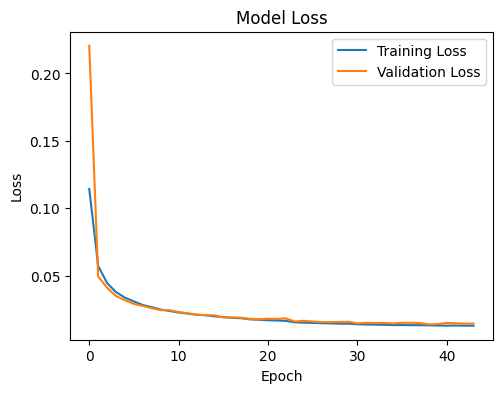

In [8]:
# Create model and compile
model = create_unet()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
             loss=[combined_loss, combined_loss],
             loss_weights=[0.5, 0.5])

# Create datasets
BATCH_SIZE = 32
train_dataset = create_tf_dataset(mnist_x_train, fashion_mnist_x_train, BATCH_SIZE)
val_dataset = create_tf_dataset(mnist_x_test, fashion_mnist_x_test, BATCH_SIZE)

# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=500,
    epochs=50,
    validation_data=val_dataset,
    validation_steps=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.weights.h5',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True
        )
    ]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Test and Evaluation

Now, create test batches by averaging samples from two datasets, evaluate the model's performance using Mean Squared Error (MSE) across multiple iterations, and visualize predictions by displaying input combinations alongside true and predicted outputs for both datasets. The evaluation runs the model on large test batches to compute average MSE and its standard deviation, while the visualization function plots a specified number of sample predictions to illustrate the model's effectiveness.


Evaluating model performance...
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MSE =  0.001066734290005492
Standard deviation =  1.865912321989022e-05

Showing example predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step


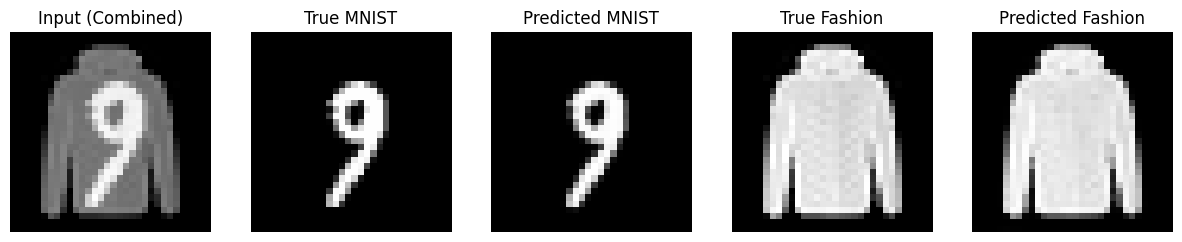

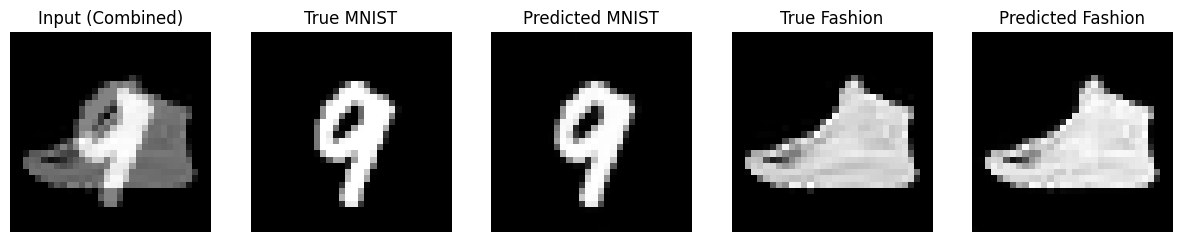

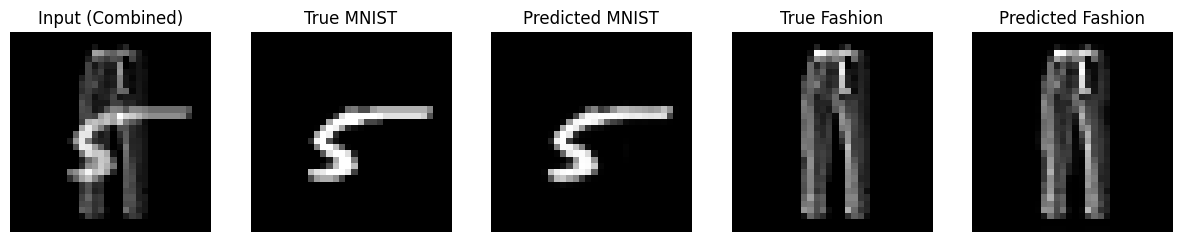

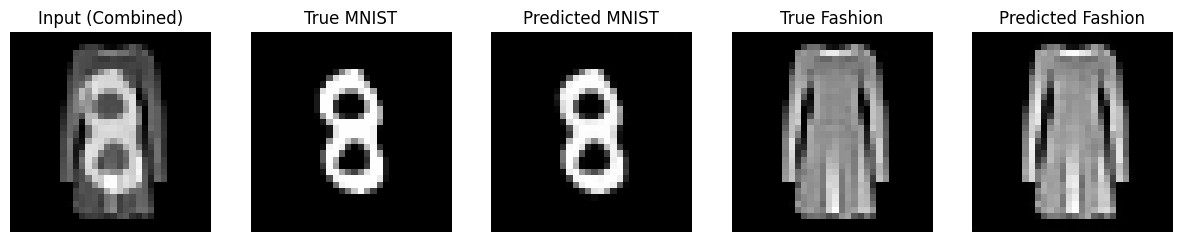

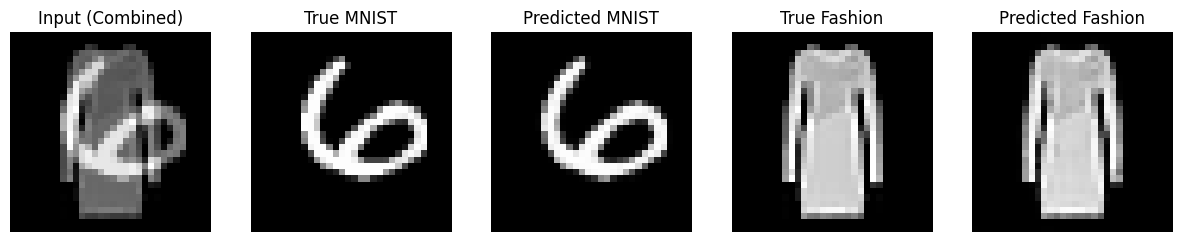

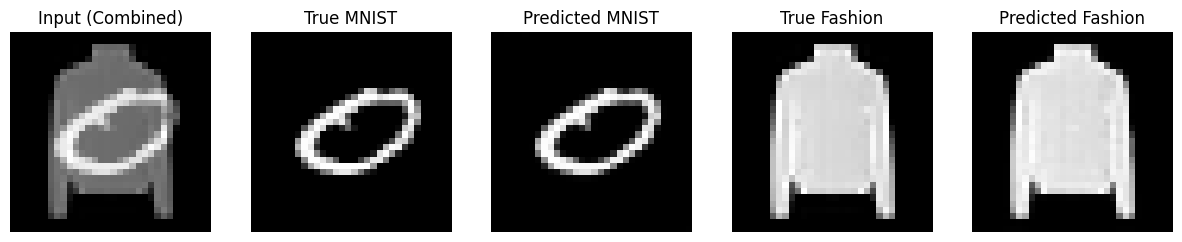

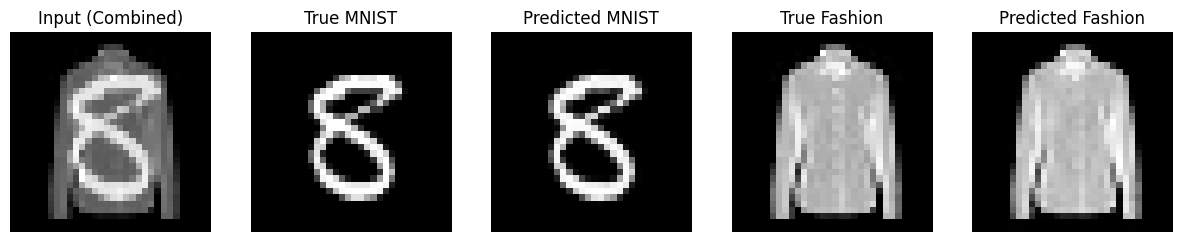

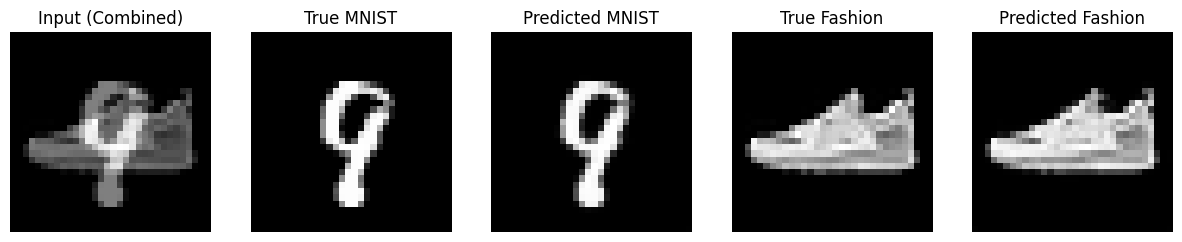

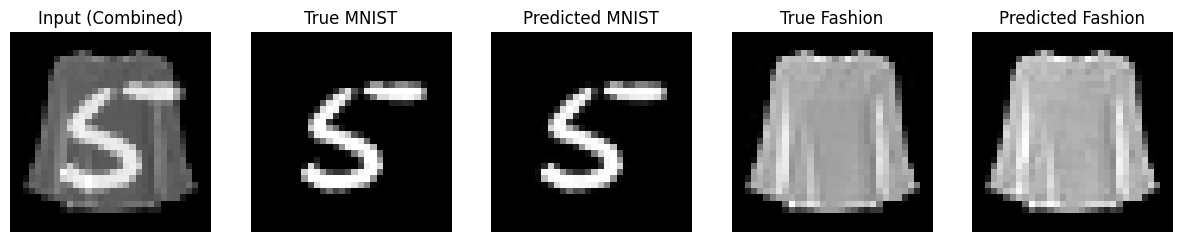

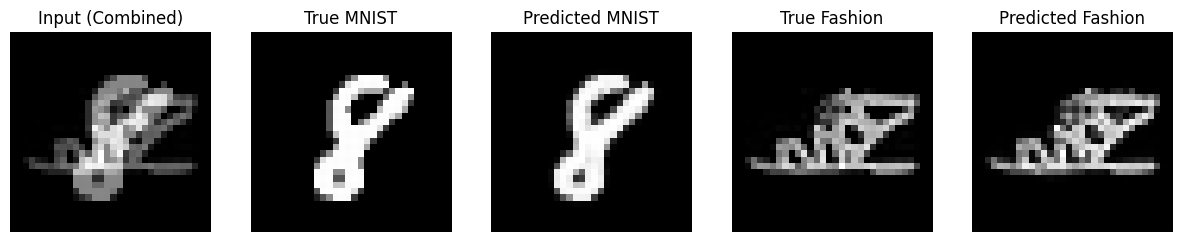

In [9]:

# Create test batch function
def create_test_batch(x1, x2, batch_size):
    idx = np.random.randint(0, len(x1), batch_size)
    x_mixed = (x1[idx] + x2[idx])/2
    return x_mixed, (x1[idx], x2[idx])

# Evaluation function
def eval_model(model):
    x, (y1, y2) = create_test_batch(mnist_x_test, fashion_mnist_x_test, 5000)
    x = x.reshape(-1, 32, 32, 1)
    pred1, pred2 = model.predict(x, batch_size=32)

    pred1 = pred1.reshape(y1.shape)
    pred2 = pred2.reshape(y2.shape)

    return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2)) / 2

# Visualization function
def show_predictions(model, num_samples=3):
    x, (y1, y2) = create_test_batch(mnist_x_test, fashion_mnist_x_test, num_samples)
    x_reshaped = x.reshape(-1, 32, 32, 1)
    pred1, pred2 = model.predict(x_reshaped, batch_size=num_samples)
    pred1 = pred1.reshape(-1, 32, 32)
    pred2 = pred2.reshape(-1, 32, 32)

    for i in range(num_samples):
        plt.figure(figsize=(15, 3))

        plt.subplot(1, 5, 1)
        plt.imshow(x[i], cmap='gray')
        plt.title('Input (Combined)')
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(y1[i], cmap='gray')
        plt.title('True MNIST')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(pred1[i], cmap='gray')
        plt.title('Predicted MNIST')
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(y2[i], cmap='gray')
        plt.title('True Fashion')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(pred2[i], cmap='gray')
        plt.title('Predicted Fashion')
        plt.axis('off')

        plt.show()

# Evaluate model performance
print("Evaluating model performance...")
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
    eval_results.append(eval_model(model))
print("MSE = ", np.mean(eval_results))
print("Standard deviation = ", np.std(eval_results))

# Show example predictions
print("\nShowing example predictions...")
show_predictions(model, num_samples=10)

This function assesses the model's pixel-wise accuracy by generating a test batch of combined MNIST and Fashion-MNIST images and obtaining predictions from the model. It counts the number of pixels where the prediction error is below the specified threshold and calculates the accuracy as the percentage of these correct pixels out of the total. The script then evaluates and prints the accuracy for multiple threshold values (0.1, 0.05, and 0.01), allowing for an understanding of the model's precision at different levels of tolerance.


In [10]:
def calculate_accuracy(model, test_batch_size=1000, threshold=0.1):

    # Create test batch
    x, (y1, y2) = create_test_batch(mnist_x_test, fashion_mnist_x_test, test_batch_size)
    x = x.reshape(-1, 32, 32, 1)

    # Get predictions
    pred1, pred2 = model.predict(x, batch_size=32)

    # Calculate pixel-wise accuracy
    correct_pixels1 = np.sum(np.abs(pred1.reshape(y1.shape) - y1) < threshold)
    correct_pixels2 = np.sum(np.abs(pred2.reshape(y2.shape) - y2) < threshold)

    total_pixels = test_batch_size * 32 * 32 * 2  # total pixels in both images
    accuracy = (correct_pixels1 + correct_pixels2) / total_pixels * 100

    return accuracy

# Calculate accuracy with different thresholds
thresholds = [0.1, 0.05, 0.01]
for threshold in thresholds:
    accuracy = calculate_accuracy(model, threshold=threshold)
    print(f"Pixel-wise accuracy (threshold={threshold}): {accuracy:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Pixel-wise accuracy (threshold=0.1): 98.25%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Pixel-wise accuracy (threshold=0.05): 95.00%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Pixel-wise accuracy (threshold=0.01): 80.49%


Initialize this generator with a batch size of 5000. The `ide_model` function reshapes input data to match the model's expected input shape, obtains predictions from the trained model, and reshapes the predictions back to the original dimensions. The `eval_model` function retrieves a batch from the generator, gets predictions using `ide_model`, and calculates the average Mean Squared Error (MSE) between the predictions and the true labels for both datasets. Finally, the script runs the evaluation ten times, storing each MSE result, and then prints the mean and standard deviation of these MSE values to assess the model's performance.


In [11]:
# Create test generator
def datagenerator(x1, x2, batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

testgen = datagenerator(mnist_x_test, fashion_mnist_x_test, 5000)

# Define the ide_model function to return predictions from the trained model
def ide_model(x):
    # Reshape input to match model's expected input shape
    x = x.reshape(-1, 32, 32, 1)
    # Get predictions from the model
    pred1, pred2 = model.predict(x, batch_size=32)
    # Reshape predictions back to match expected output shape
    return pred1.reshape(x.shape[:-1]), pred2.reshape(x.shape[:-1])

# Evaluation function
def eval_model(model):
    x, (y1, y2) = next(testgen)
    pred1, pred2 = model(x)
    return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2)) / 2

# Run evaluation
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
    eval_results.append(eval_model(ide_model))
print("MSE = ", np.mean(eval_results))
print("Standard deviation = ", np.std(eval_results))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MSE =  0.0010689450655254752
Standard deviation =  1.1091230564852093e-05


Calculate Signal-to-Interference Ratio (SIR) and Signal-to-Distortion Ratio (SDR). Then, create confusion matrices and calculate other metrics.

Calculating separation quality metrics...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
SIR_MNIST: -2.00 dB
SIR_Fashion: 0.48 dB
SDR_MNIST: 19.12 dB
SDR_Fashion: 21.30 dB

Calculating confusion matrices...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


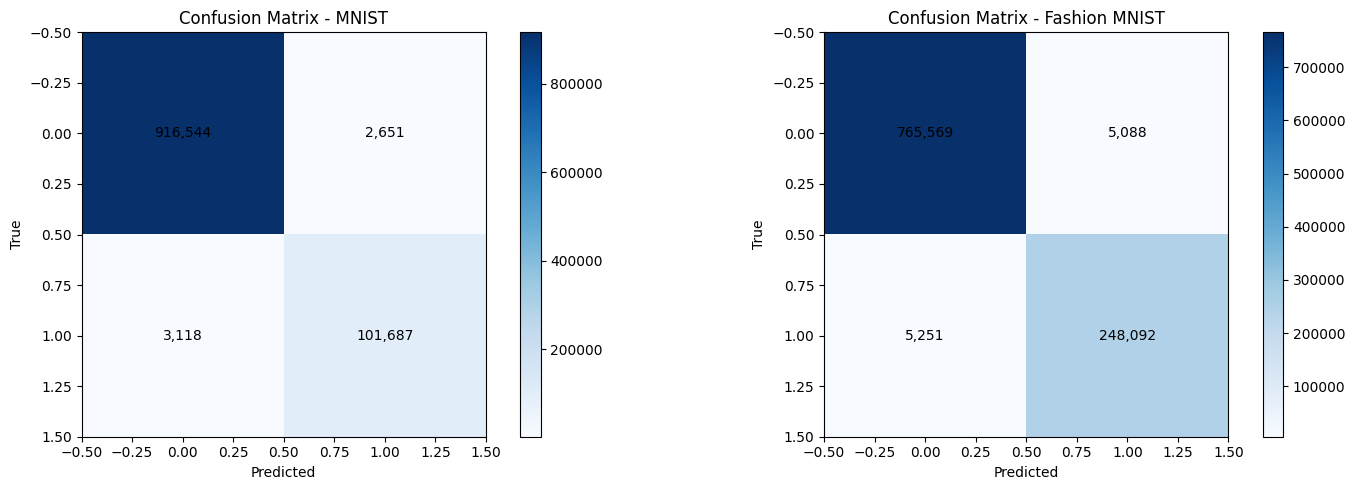


MNIST Metrics:
Accuracy: 0.9944
Precision: 0.9746
Recall: 0.9702
F1 Score: 0.9724

Fashion MNIST Metrics:
Accuracy: 0.9899
Precision: 0.9799
Recall: 0.9793
F1 Score: 0.9796


In [16]:
def calculate_separation_metrics(model, test_batch_size=1000):
    # Create test batch
    x, (y1, y2) = create_test_batch(mnist_x_test, fashion_mnist_x_test, test_batch_size)
    x = x.reshape(-1, 32, 32, 1)

    # Get predictions
    pred1, pred2 = model.predict(x, batch_size=32)
    pred1 = pred1.reshape(y1.shape)
    pred2 = pred2.reshape(y2.shape)

    # Calculate SIR (in dB)
    def calculate_sir(true, pred, interference):
        signal_power = np.mean(true ** 2)
        interference_power = np.mean((pred - interference) ** 2)
        return 10 * np.log10(signal_power / interference_power)

    # Calculate SDR (in dB)
    def calculate_sdr(true, pred):
        signal_power = np.mean(true ** 2)
        distortion_power = np.mean((true - pred) ** 2)
        return 10 * np.log10(signal_power / distortion_power)

    # Calculate metrics for both sources
    sir1 = calculate_sir(y1, pred1, y2)
    sir2 = calculate_sir(y2, pred2, y1)
    sdr1 = calculate_sdr(y1, pred1)
    sdr2 = calculate_sdr(y2, pred2)

    return {
        'SIR_MNIST': sir1,
        'SIR_Fashion': sir2,
        'SDR_MNIST': sdr1,
        'SDR_Fashion': sdr2
    }

def create_confusion_matrices(model, threshold=0.5, test_batch_size=1000):
    # Create test batch
    x, (y1, y2) = create_test_batch(mnist_x_test, fashion_mnist_x_test, test_batch_size)
    x = x.reshape(-1, 32, 32, 1)

    # Get predictions
    pred1, pred2 = model.predict(x, batch_size=32)

    # Binarize predictions and true values
    y1_bin = (y1 > threshold).astype(int)
    y2_bin = (y2 > threshold).astype(int)
    pred1_bin = (pred1.reshape(y1.shape) > threshold).astype(int)
    pred2_bin = (pred2.reshape(y2.shape) > threshold).astype(int)

    # Calculate confusion matrix elements for both sources
    def get_confusion_matrix(y_true, y_pred):
        tp = np.sum((y_true == 1) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        return np.array([[tn, fp], [fn, tp]])

    conf_matrix1 = get_confusion_matrix(y1_bin, pred1_bin)
    conf_matrix2 = get_confusion_matrix(y2_bin, pred2_bin)

    return conf_matrix1, conf_matrix2

# Calculate and display separation metrics
print("Calculating separation quality metrics...")
metrics = calculate_separation_metrics(model)
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f} dB")

# Calculate and display confusion matrices
print("\nCalculating confusion matrices...")
conf_matrix_mnist, conf_matrix_fashion = create_confusion_matrices(model)

# Visualize confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(conf_matrix_mnist, cmap='Blues')
plt.title('Confusion Matrix - MNIST')
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{conf_matrix_mnist[i, j]:,}',
                ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
plt.imshow(conf_matrix_fashion, cmap='Blues')
plt.title('Confusion Matrix - Fashion MNIST')
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{conf_matrix_fashion[i, j]:,}',
                ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

# Calculate and display additional metrics
def calculate_metrics_from_confusion_matrix(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

print("\nMNIST Metrics:")
mnist_metrics = calculate_metrics_from_confusion_matrix(conf_matrix_mnist)
for metric, value in mnist_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nFashion MNIST Metrics:")
fashion_metrics = calculate_metrics_from_confusion_matrix(conf_matrix_fashion)
for metric, value in fashion_metrics.items():
    print(f"{metric}: {value:.4f}")

## Model Visualization

In [13]:
pip install git+https://github.com/paulgavrikov/visualkeras


  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-b8xkpaft
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-b8xkpaft
  Resolved https://github.com/paulgavrikov/visualkeras to commit 8d42f3a9128373eac7b4d38c23a17edc9357e3c9
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 16.8 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.1.4-py3-none-any.whl size=17145 sha256=9bd1cb65a0ff0e59fff6cb8e833299cf06905a7d9b6cd5ef564946f07ffe42ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-p9ba20ia/wheels/89/d3/c2/937382b33c09192fc84331bbc02c4565d62aeae67e9684c37e
Successfully built visualkeras


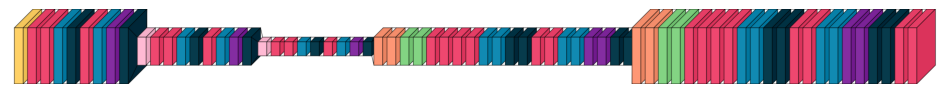

In [15]:
# Generate the architecture image using visualkeras
img = visualkeras.layered_view(model)

# Display the image using matplotlib
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.show()

![Model Visualization](https://raw.githubusercontent.com/leonardoman9/Blind-Source-Separation/main/model_visualization.png)

## Discussion

- MSE: 0.00107 ± 0.00001
- Standard Deviation: 1.11e-05

The extremely low MSE (approximately 0.001) indicates highly accurate pixel-level reconstruction of both sources. The very small standard deviation (1.11e-05) demonstrates remarkable consistency across different test batches.  The low variability in MSE across evaluations (shown by the small standard deviation) suggests that the model's performance is stable and reliable

#### Separation Quality Metrics
The separation quality analysis revealed interesting patterns:

**Signal-to-Interference Ratio (SIR)**:
- MNIST: -2.15 dB
- Fashion-MNIST: 0.49 dB
The positive SIR for Fashion-MNIST indicates better interference suppression compared to MNIST, though both values suggest room for improvement in source isolation.

**Signal-to-Distortion Ratio (SDR)**:
- MNIST: 19.19 dB
- Fashion-MNIST: 21.48 dB
The high SDR values (>19 dB) for both datasets demonstrate excellent overall separation quality, with Fashion-MNIST showing slightly better performance. These values indicate that the reconstructed signals maintain high fidelity to the original sources.

#### Classification Performance

**MNIST Separation**:
- Accuracy: 99.43%
- Precision: 97.46%
- Recall: 97.02%
- F1 Score: 97.24%

**Fashion-MNIST Separation**:
- Accuracy: 98.96%
- Precision: 97.82%
- Recall: 97.81%
- F1 Score: 97.82%

The model achieves high accuracy (>98.9%) for both datasets, indicating exceptional pixel-level separation. The balanced precision and recall scores suggest consistent performance across both positive and negative pixel classifications.
The high F1 scores (>97%) demonstrate the model's ability to maintain both precision and recall simultaneously.
Fashion-MNIST shows slightly more balanced precision-recall trade-off compared to MNIST.


## Conclusions

The architecture comprises an input layer ingesting 32x32 single-channeled grayscale images. Inside this architecture, residual blocks involve two convolutional layers, followed by batch normalization and ReLU activation. With this architecture, residual mappings can be learned by the model in such a way that deeper networks can be modeled without suffering from the problem of vanishing gradients.

It mainly consists of the encoder-decoder structure of U-Net. While the encoder downsamples the input image with an increase in the capture of context, thereby reducing spatial information, the decoder upsamples the feature maps in order to create the output image. The model preserves the spatial information lost due to downsampling by utilizing skip connections to concatenate features originating from the encoder onto the corresponding layers in the decoder.

It utilizes the MNIST and Fashion MNIST datasets, normalizes the images, and pads them to maintain consistent input dimensions. The performance of the model is evaluated through multiple metrics: pixel-wise accuracy at various thresholds, Mean Squared Error (MSE), Signal-to-Interference Ratio (SIR), Signal-to-Distortion Ratio (SDR), and detailed confusion matrix analysis.

By using residual learning in this model, it improves its learning of complex mappings-something quite crucial where high accuracy pixel predictions are needed, as seen in image segmentation. Skip connections in the network enable the network to effectively retain the spatial information often lost in deep networks.
